# VKLIKE TF2

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/DATA/20220424-vklike_dataset.zip /content
!unzip -qq -d /content /content/20220424-vklike_dataset.zip
!ls /content

20220424-vklike_dataset  20220424-vklike_dataset.zip  gdrive  sample_data


In [3]:
!ls /content/20220424-vklike_dataset

dislike  like  lobe-bf07e5dd7a5d4a398e09d19ce4215f74.csv


Завершили скачивание и распаковку датасета. Это можно сделать либо ячейками выше, либо вручную.

In [5]:
import tensorflow as tf

In [6]:
# Генерируем обучающую и валидационной выборки.
VALIDATION_SPLIT = 0.2
SEED = 1337
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 32

DATA = '/content/20220424-vklike_dataset'

# Keras понимает, что 2 класса, потому что 2 директории (Cats, Dogs).
# Автоматически будут созданы два лейбла (0 - Cat, 1 - Dog).

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    DATA,
    validation_split = VALIDATION_SPLIT,
    subset = "training",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

validation_images = tf.keras.preprocessing.image_dataset_from_directory(
    DATA,
    validation_split = VALIDATION_SPLIT,
    subset = "validation",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 8444 files belonging to 2 classes.
Using 6756 files for training.
Found 8444 files belonging to 2 classes.
Using 1688 files for validation.


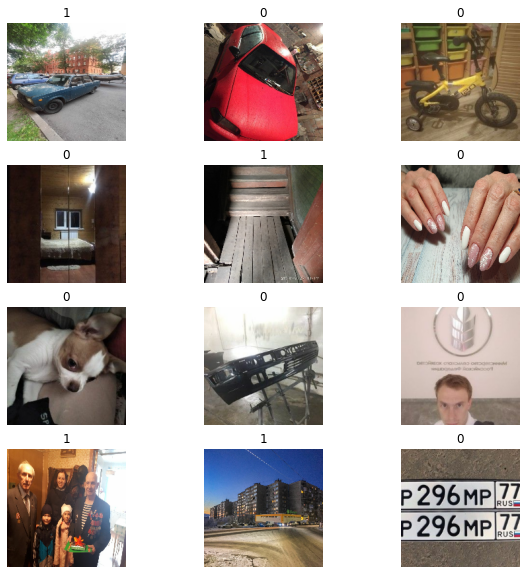

In [9]:
# Посмотрим на изображения.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_images.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
# Сделаем вспомогательную структуру для наращивания обучающей выборки.
augmentation_network = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    # tf.keras.layers.RandomContrast(0.1, seed=42),
])

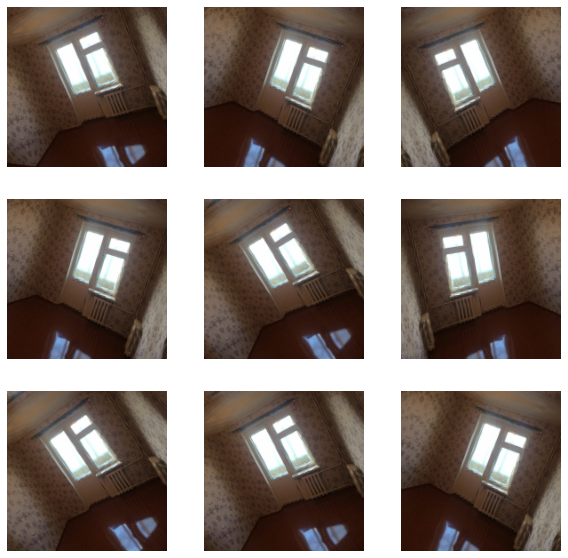

In [13]:
# Пример того, как она работает.
plt.figure(figsize=(10, 10))
for images, _ in training_images.take(1):
    for i in range(9):
        augmented_images = augmentation_network(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Нарастим обучающую выборку.
augmented_training_images = training_images.map(
  lambda image, label: (augmentation_network(image, training = True), label)
)

In [14]:
# Буферизируем ввод.
training_images = training_images.prefetch(buffer_size=32)
validation_images = validation_images.prefetch(buffer_size=32)

In [15]:
# Метод для создания модели Xception network.
def build_xception_network(input_shape, num_classes):
    inputs = tf.keras.Input(shape = input_shape)

    # Наращивание можно сделать частью архитектуры нейронной сети.
    #x = augmentation_network(inputs)

    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)

In [18]:
# Создаём модель.
model = build_xception_network(input_shape = IMAGE_SIZE + (3,), num_classes = 2)

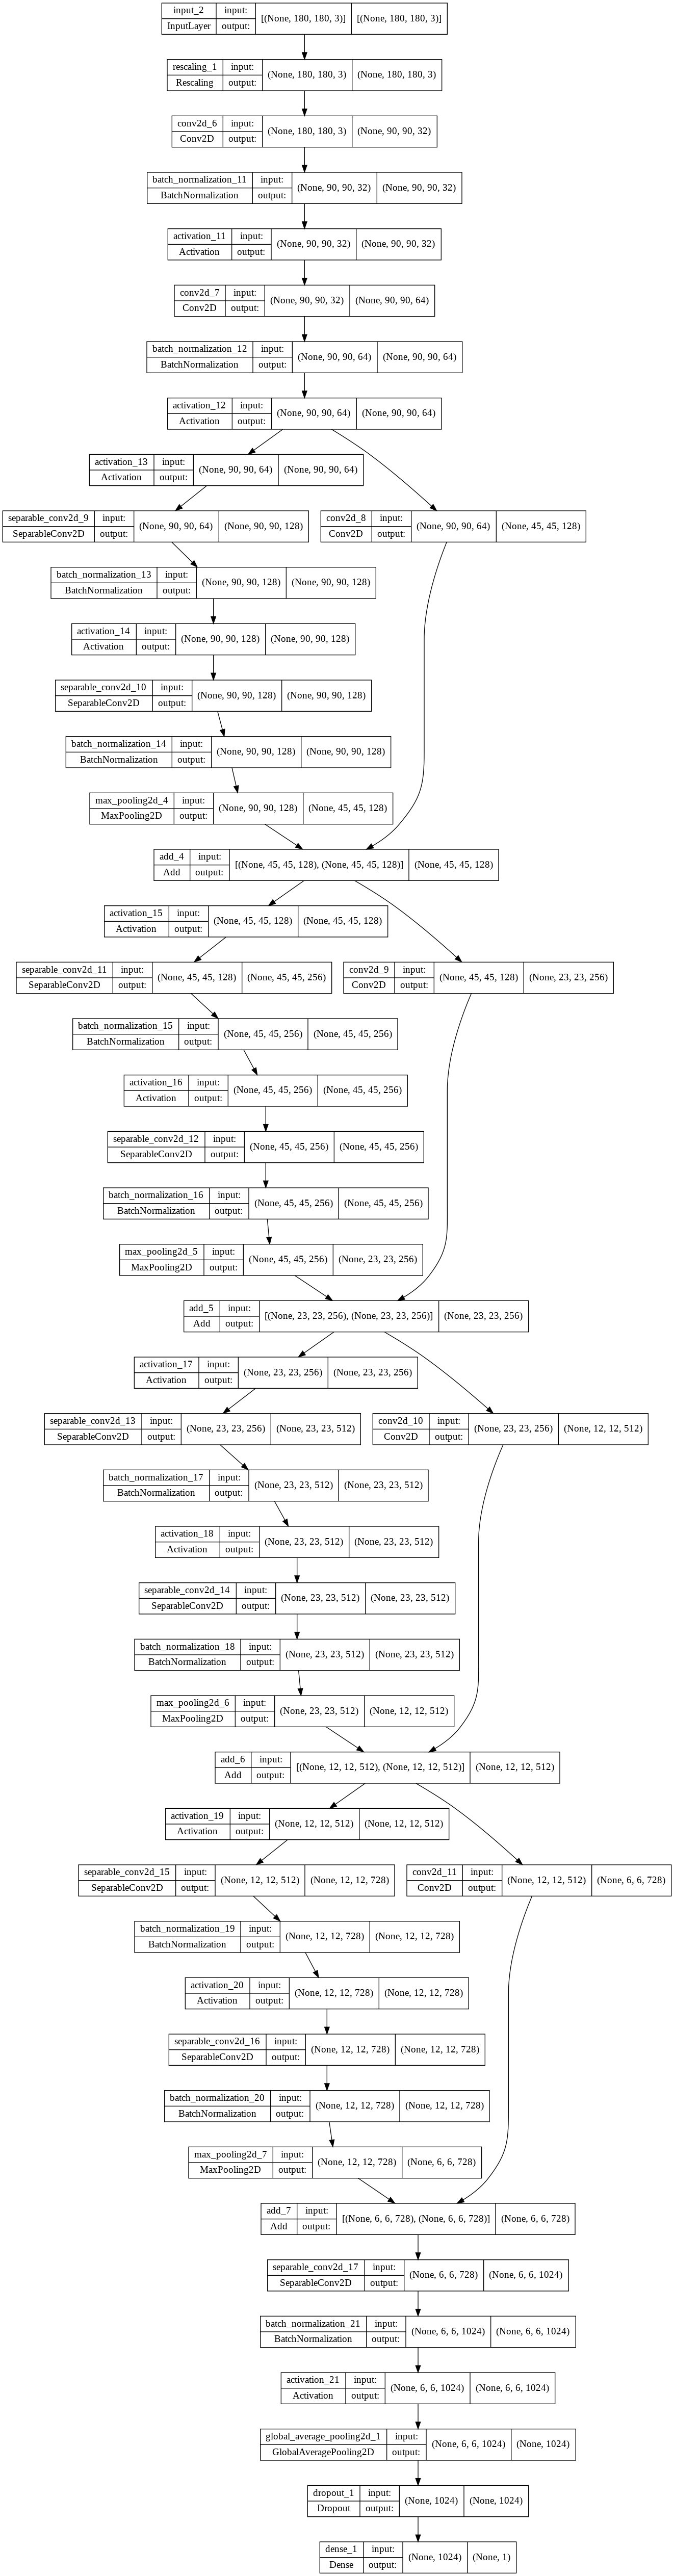

In [19]:
# Визуализируем её.
tf.keras.utils.plot_model(model, show_shapes = True)

In [21]:
# callback для сохранения результатов обучения в формате Keras (h5) после каждой эпохи обучения.
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("vklike_model/epoch_{epoch}.h5")
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [22]:
EPOCHS = 50

model.fit(
    training_images, epochs=EPOCHS, callbacks=callbacks, validation_data=validation_images
)

Epoch 1/50
212/212 [==============================] - 122s 502ms/step - loss: 0.6627 - accuracy: 0.6468 - val_loss: 0.8323 - val_accuracy: 0.4941
Epoch 2/50
212/212 [==============================] - 105s 493ms/step - loss: 0.5937 - accuracy: 0.6926 - val_loss: 0.8819 - val_accuracy: 0.4970
Epoch 3/50
212/212 [==============================] - 106s 493ms/step - loss: 0.5648 - accuracy: 0.7112 - val_loss: 0.5589 - val_accuracy: 0.7162
Epoch 4/50
212/212 [==============================] - 105s 492ms/step - loss: 0.5317 - accuracy: 0.7319 - val_loss: 0.6633 - val_accuracy: 0.6842
Epoch 5/50
212/212 [==============================] - 105s 491ms/step - loss: 0.5106 - accuracy: 0.7382 - val_loss: 0.5505 - val_accuracy: 0.7305
Epoch 6/50
212/212 [==============================] - 105s 493ms/step - loss: 0.4882 - accuracy: 0.7632 - val_loss: 0.5954 - val_accuracy: 0.7079
Epoch 7/50
212/212 [==============================] - 105s 492ms/step - loss: 0.4642 - accuracy: 0.7806 - val_loss: 0.5441 -

In [23]:
# Сохраняем модель целиком в формате TensorFlow (saved_model.pb + variables/).
model.save("vklike_model")

INFO:tensorflow:Assets written to: vklike_model/assets


In [ ]:
# Либо загружаем весовые коэффециенты от заранее обученной модели в формате Keras (h5).
model.load_weights('vklike_model/epoch_48.h5')

In [ ]:
# Либо загружаем заранее обученную модель целиком из формата TensorFlow (saved_model.pb + variables/).
model = tf.keras.models.load_model("vklike_model")

Image is LIKE with 0.9998393058776855 confidence


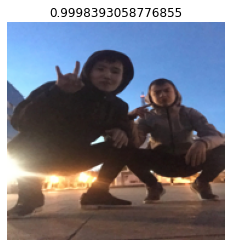

In [34]:
import requests
from PIL import Image

url = 'https://sun9-77.userapi.com/impg/Xv8dJh4OnSgY2ZAc04-_L7SokiJCxmwDKv2PrQ/_htEJkgpA0M.jpg?size=811x1080&quality=96&sign=1641ab517a74fa2e23ef2b0d2acf9ecf&c_uniq_tag=xhbHQL3zHtK59Dfuyz47cQPIIrBtDgIkP_VVRCPXoR0&type=album'
res = requests.get(url, stream=True)
# img = tf.keras.preprocessing.image.load_img(
#     "<path_to_image>", target_size=IMAGE_SIZE
# )
img = Image.open(res.raw)
img = img.resize(IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0][0]
plt.imshow(img)
plt.title(f"{score}")
plt.axis("off")

print(
    f"Image is LIKE with {score} confidence"
)